### Import libraries and load data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load and verify data
ab_data = pd.read_csv('C:\Users\harsh\Downloads\E-Commerce Dataset\ecommerce-ab-testing-2022-dataset1\ecommerce_ab_testing_2022_dataset1\ab_data.csv')
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
# Load country mapping
country_data = pd.read_csv('C:\Users\harsh\Downloads\E-Commerce Dataset\ecommerce-ab-testing-2022-dataset1\ecommerce_ab_testing_2022_dataset1\countries.csv')
country_data.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [5]:
# Merge on user_id
df = ab_data.merge(country_data, on='user_id', how='left')
df.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


#### Data quality

In [6]:
# Check assignment consistency
cross_tab = pd.crosstab(df['group'], df['landing_page'])
print(f"Assignment consistency:\n{cross_tab}")

# Remove mismatches
clean_data = df.query('(group == "control" & landing_page == "old_page") | (group == "treatment" & landing_page == "new_page")')

Assignment consistency:
landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145315      1965


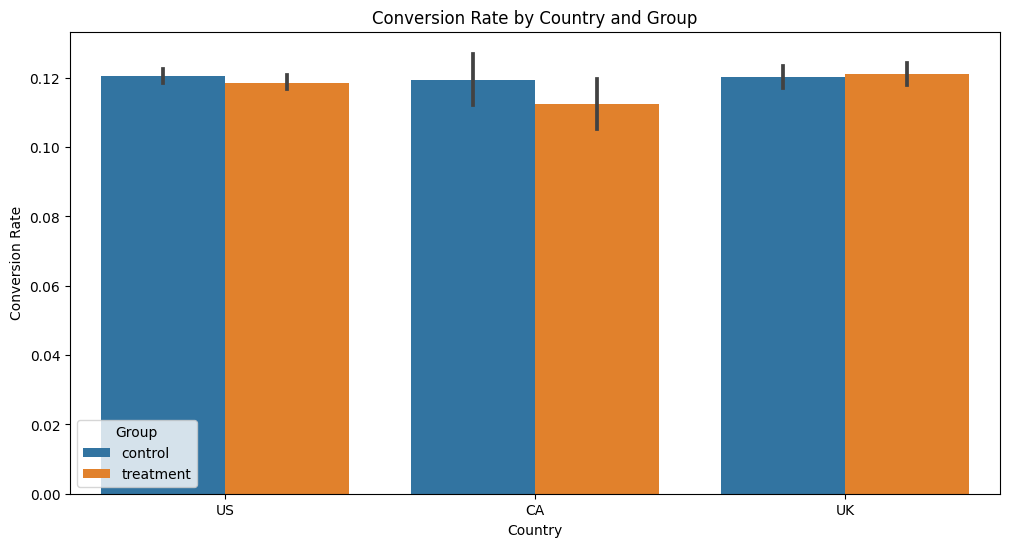

In [7]:
# Conversion Rate by Group and Country
plt.figure(figsize=(12,6))
sns.barplot(data=df, x='country', y='converted', hue='group')
plt.title('Conversion Rate by Country and Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Country')
plt.legend(title='Group')
plt.show()

#### Timestamp Handling & Period Definition
For DiD, we need a 'pre' and 'post' period.
**Assumption:** The timestamp is a string (e.g. "11:48.6").

In [8]:
# If timestamp is not a real date, simulate a split
split_idx = len(df) // 2
df = df.sort_values('user_id').reset_index(drop=True)
df['period'] = 0
df.loc[split_idx:, 'period'] = 1  # 0 = pre, 1 = post

#### A/B Tests
Let's measure the effect of the new page on conversion, both overall and by country.

In [9]:
# Overall A/B Test
ab_summary = df.groupby('group')['converted'].agg(['mean', 'count'])
control_mean = ab_summary.loc['control', 'mean']
treatment_mean = ab_summary.loc['treatment', 'mean']
n_control = ab_summary.loc['control', 'count']
n_treatment = ab_summary.loc['treatment', 'count']

# Z-test
pooled_prob = (control_mean * n_control + treatment_mean * n_treatment) / (n_control + n_treatment)
se = np.sqrt(pooled_prob * (1 - pooled_prob) * (1/n_control + 1/n_treatment))
z_score = (treatment_mean - control_mean) / se
p_value = 1 - stats.norm.cdf(z_score)

print(f"Overall A/B Test:\nControl: {control_mean:.4f}, Treatment: {treatment_mean:.4f}")
print(f"Z-score: {z_score:.3f}, p-value: {p_value:.4f}")

# A/B Test per country
country_ab = []
for country, sub in df.groupby('country'):
    ab = sub.groupby('group')['converted'].agg(['mean', 'count'])
    if 'control' in ab.index and 'treatment' in ab.index:
        c_mean, c_n = ab.loc['control', 'mean'], ab.loc['control', 'count']
        t_mean, t_n = ab.loc['treatment', 'mean'], ab.loc['treatment', 'count']
        pooled = (c_mean * c_n + t_mean * t_n) / (c_n + t_n)
        se = np.sqrt(pooled * (1 - pooled) * (1/c_n + 1/t_n))
        z = (t_mean - c_mean) / se if se > 0 else np.nan
        p = 1 - stats.norm.cdf(z) if not np.isnan(z) else np.nan
        country_ab.append({'country': country, 'control_mean': c_mean, 'treatment_mean': t_mean, 'z_score': z, 'p_value': p})

country_ab_df = pd.DataFrame(country_ab)
print("\nA/B Test Results by Country:")
print(country_ab_df[['country', 'control_mean', 'treatment_mean', 'z_score', 'p_value']])

Overall A/B Test:
Control: 0.1204, Treatment: 0.1189
Z-score: -1.240, p-value: 0.8924

A/B Test Results by Country:
  country  control_mean  treatment_mean   z_score   p_value
0      CA      0.119282        0.112539 -1.276898  0.899181
1      UK      0.120192        0.120974  0.325416  0.372433
2      US      0.120552        0.118644 -1.335741  0.909183


#### Difference-in-Differences (DiD) Analysis
DiD controls for time effects and estimates the causal effect of the new page, both overall and by country.


##### Create synthetic time and assign pre/post

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

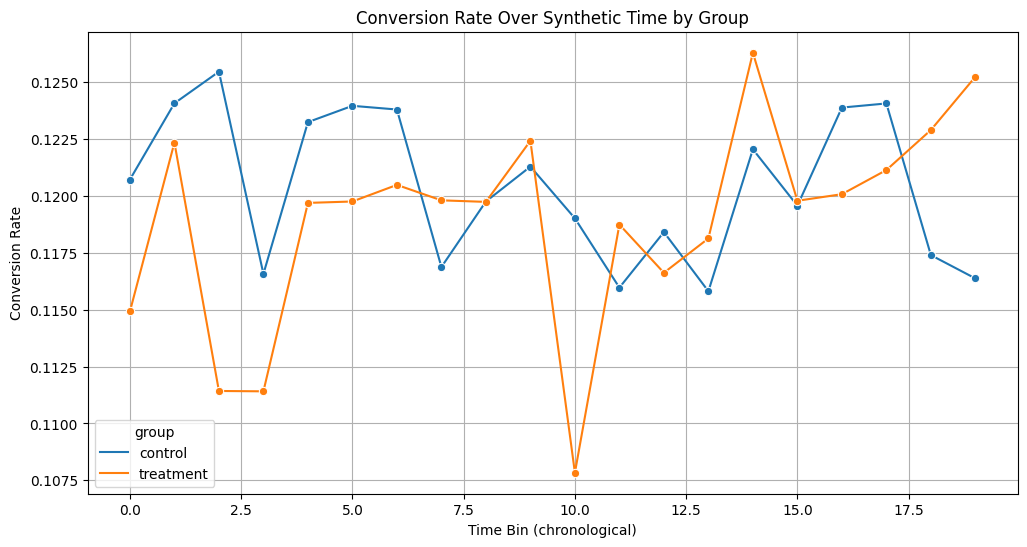

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.386
Date:                Thu, 13 Nov 2025   Prob (F-statistic):              0.245
Time:                        11:38:29   Log-Likelihood:                -86474.
No. Observations:              294482   AIC:                         1.730e+05
Df Residuals:                  294478   BIC:                         1.730e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1216      0.001    101.574      0.0

In [10]:
# Add a pseudo-time column based on row order
df = df.reset_index(drop=True)
df['time_index'] = df.index

# Simulate pre/post periods (50% split)
mid_point = len(df) // 2
df['time'] = (df['time_index'] >= mid_point).astype(int)  # 0 = pre, 1 = post

# Binary treatment group
df['treatment'] = (df['group'] == 'treatment').astype(int)

# DiD interaction
df['did'] = df['time'] * df['treatment']


import seaborn as sns
import matplotlib.pyplot as plt

# Bin time_index to reduce noise
df['time_bin'] = pd.qcut(df['time_index'], q=20, labels=False)

# Average conversion over time bins
trend = df.groupby(['time_bin', 'group'])['converted'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend, x='time_bin', y='converted', hue='group', marker='o')
plt.title("Conversion Rate Over Synthetic Time by Group")
plt.xlabel("Time Bin (chronological)")
plt.ylabel("Conversion Rate")
plt.grid(True)
plt.show()

import statsmodels.api as sm

X = sm.add_constant(df[['time', 'treatment', 'did']])
y = df['converted']
model = sm.OLS(y, X).fit()
print(model.summary())

In [11]:
# Encode group and period
df['treatment'] = (df['group'] == 'treatment').astype(int)

# DiD interaction term
df['did'] = df['treatment'] * df['period']

# DiD regression (overall)
X = sm.add_constant(df[['treatment', 'period', 'did']])
y = df['converted']
model = sm.OLS(y, X).fit()
print("\nOverall DiD Regression Results:")
print(model.summary())

# DiD per country
did_country_results = []
for country, sub in df.groupby('country'):
    if sub['treatment'].nunique() < 2 or sub['period'].nunique() < 2:
        continue  # skip if not enough variation
    Xc = sm.add_constant(sub[['treatment', 'period', 'did']])
    yc = sub['converted']
    m = sm.OLS(yc, Xc).fit()
    did_country_results.append({
        'country': country,
        'DiD_coef': m.params['did'],
        'p_value': m.pvalues['did'],
        'n': len(sub)
    })

did_country_df = pd.DataFrame(did_country_results)
print("\nDiD Results by Country:")
print(did_country_df[['country', 'DiD_coef', 'p_value', 'n']])


Overall DiD Regression Results:
                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.386
Date:                Thu, 13 Nov 2025   Prob (F-statistic):              0.245
Time:                        11:38:29   Log-Likelihood:                -86474.
No. Observations:              294482   AIC:                         1.730e+05
Df Residuals:                  294478   BIC:                         1.730e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.12

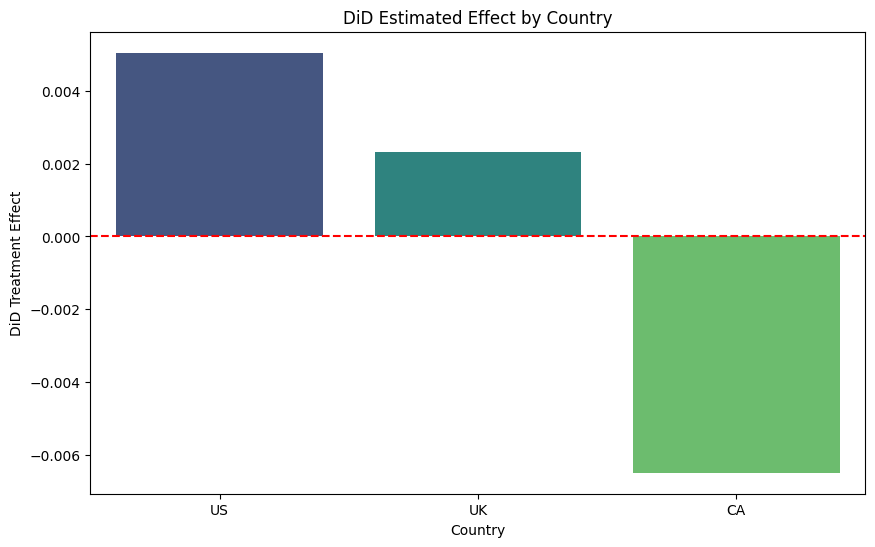

In [12]:
# DiD Effect by Country
plt.figure(figsize=(10,6))
sns.barplot(data=did_country_df.sort_values('DiD_coef', ascending=False), x='country', y='DiD_coef', palette='viridis')
plt.axhline(0, color='red', linestyle='--')
plt.title('DiD Estimated Effect by Country')
plt.ylabel('DiD Treatment Effect')
plt.xlabel('Country')
plt.show()

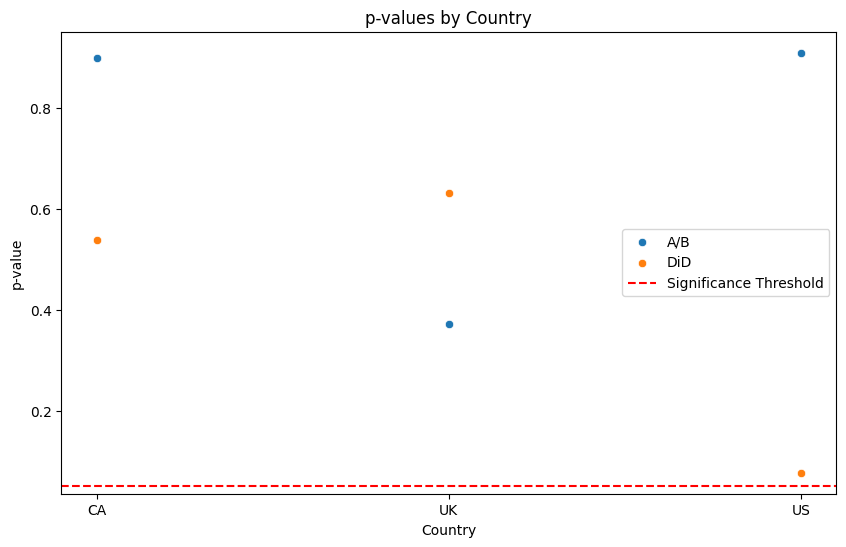

In [13]:
# p-values by Country (for A/B and DiD)
plt.figure(figsize=(10,6))
sns.scatterplot(data=country_ab_df, x='country', y='p_value', label='A/B')
sns.scatterplot(data=did_country_df, x='country', y='p_value', label='DiD')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold')
plt.title('p-values by Country')
plt.ylabel('p-value')
plt.xlabel('Country')
plt.legend()
plt.show()